### *Data Analysis*
##  Plot Prevalence Score and prepare Multivariate Regression for the Speaker Corpus, U.S. 
---
*conducted in May 2022*

In [1]:
from nltk.probability import FreqDist
import statistics
from matplotlib import pyplot
import pandas as pd
from scipy.stats import fisher_exact
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.mosaicplot import mosaic
import math
import os
from matplotlib import cm
from colorspacious import cspace_converter
import docx
import altair as alt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import imblearn
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

/Users/charlottekaiser/miniforge3/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


---
### 1. Prepare prevalence data for descriptives 

In [2]:
expost_us = pd.read_csv(r"/Users/charlottekaiser/Documents/uni/Hertie/master_thesis/00_data/50_analysis/LDA_mallet_us.csv")

In [3]:
expost_us = expost_us.drop(columns=['Unnamed: 0', 'level', 'text', 'Document_No', 'Keywords'])

In [4]:
# Add the prevalences for both topics to prepare for multivariate regression and drop old topics that create confusion
expost_us["prev_nat_sec"] = np.nan
expost_us["prev_econ"] = np.nan
expost_us.loc[expost_us['Dominant_Topic'] == 0, ['prev_nat_sec']] = expost_us["Topic_Perc_Contrib"]
expost_us.loc[expost_us['Dominant_Topic'] == 1, ['prev_econ']] = expost_us["Topic_Perc_Contrib"]
expost_us.loc[expost_us['Dominant_Topic'] == 0, ['prev_econ']] = 1 - expost_us["prev_nat_sec"]
expost_us.loc[expost_us['Dominant_Topic'] == 1, ['prev_nat_sec']] = 1 - expost_us["prev_econ"]
expost_us = expost_us.drop(columns=['prevalenc_of_topics', 'Topic_Perc_Contrib'])

---
#### 1.2 Calculate the mean prevalence scores

In [5]:
# Calculating the mean prevalence scores for each topic
mean_nat_sec = expost_us["prev_nat_sec"].mean()
mean_econ = expost_us["prev_econ"].mean()


In [6]:
# initialize data of lists.
means = {'topic':['National_security', 'Domestic_us_economy'],
        'mean':[mean_nat_sec, mean_econ]}
 
# Create DataFrame
means = pd.DataFrame(means)

In [7]:
means

,topic,mean
0,National_security,0.549089
1,Domestic_us_economy,0.450911


In [8]:
means["percentage"] = means["mean"]*100

In [9]:
means

,topic,mean,percentage
0,National_security,0.549089,54.908861
1,Domestic_us_economy,0.450911,45.091139


---
### 2. Collect descriptives and visualise

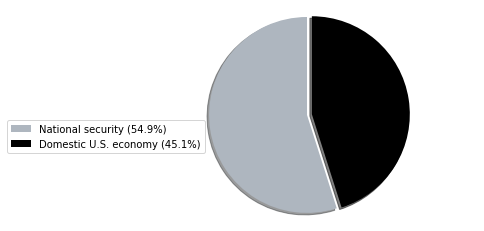

In [10]:
# Pie chart to plot distribution
labels = 'National security (54.9%)', 'Domestic U.S. economy (45.1%)' 
sizes = [54.908861, 45.091139]
explode = (0.05, 0)  
colors = ['#AEB6BF', 'black']
patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90, explode=explode)
plt.legend(patches, labels, loc='upper right', bbox_to_anchor=(0.2, 0.5))
plt.axis('equal')
plt.show()

In [11]:
# Count dominance of topics
expost_us["Dominant_Topic"].value_counts()

0    51
1    28
Name: Dominant_Topic, dtype: int64

In [12]:
expost_us[19:]

,speaker,gender,state,house_of_rep,party,Dominant_Topic,Dominant_topic,prev_nat_sec,prev_econ
19,Cynthia Lummis,1,Wyoming,1,0,1,Domestic_us_economy,0.2440,0.7560
20,French Hill,0,Arkansas,1,0,0,National_security,0.5192,0.4808
21,Jared Golden,0,Maine,1,1,0,National_security,0.7246,0.2754
22,Joe Courtney,0,Connecticut,1,1,0,National_security,0.6594,0.3406
23,Patrick McHenry,0,North Carolina,1,0,0,National_security,0.6453,0.3547
24,Gregory Meeks,0,New York,1,1,0,National_security,0.6239,0.3761
25,Raja Krishnamoorthi,0,Illinois,1,1,1,Domestic_us_economy,0.4202,0.5798
26,Rick Crawford,0,Arkansas,1,0,0,National_security,0.6247,0.3753
27,Donald Norcross,0,New Jersey,1,1,0,National_security,0.7104,0.2896
28,Robin Kelly,1,Illinois,1,1,0,National_security,0.6312,0.3688


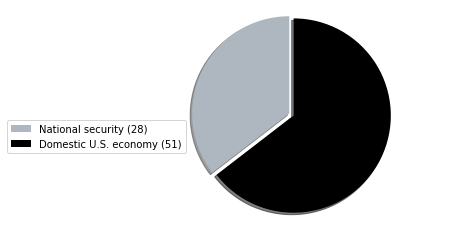

In [13]:
# Create pie chart
labels = 'National security (28)', 'Domestic U.S. economy (51)' 
sizes = [28, 51]
explode = (0, 0.05)  
colors = ['#AEB6BF', 'black']
patches, texts = plt.pie(sizes, colors=colors, shadow=True, startangle=90, explode=explode)
plt.legend(patches, labels, loc='upper right', bbox_to_anchor=(0.2, 0.5))
plt.axis('equal')
plt.show()

In [14]:
# Save dataframe
means.to_csv('/Users/charlottekaiser/Documents/uni/Hertie/master_thesis/00_data/50_analysis/prevalence_means-us.csv')  

---
### 3. Prepare dataframe for multivariate regression in R

In [20]:
# Investigate the states we have and clean up the variable
expost_us["state"].unique()
expost_us.loc[expost_us['state'] == "California ", ['state']] = "California"
expost_us.loc[expost_us['state'] == "\xa0Oklahoma" ,['state']] = "Oklahoma"
expost_us.loc[expost_us['state'] == "\xa0Iowa" ,['state']] = "Iaowa"

array(['California', 'Texas', 'Florida', 'Arizona', 'Michigan',
       'Illinois', 'Pennsylvania', 'Wisconsin', 'Oklahoma', 'Maine',
       'Ohio', 'Alaska', 'Colorado', 'Wyoming', 'Arkansas', 'Connecticut',
       'North Carolina', 'New York', 'New Jersey', 'Montana', 'Iaowa',
       'Kentucky', 'Nebraska', 'Missouri', 'Mississippi', 'Indiana',
       'Tennessee', 'District of Columbia', 'Rhode Island', 'Washington',
       'Puerto Rico', 'Alabama', 'South Dakota', 'Virginia'], dtype=object)

Also cluster for military: <br>
"The five states with the most total active-duty and reserve members of the military, as of September 2021, were: <br>
- 217,889 in California
- 174,598 in Texas
- 156,475 in Virginia
- 122,214 in North Carolina
- 107,385 in Florida" 

*Source: https://www.governing.com/now/2021-military-active-duty-personnel-civilians-by-state*

In [16]:
# Build dummy for military heavy states
expost_us["military_heavy"] = 0
expost_us.loc[expost_us['state'] == 'California', ['military_heavy']] = 1
expost_us.loc[expost_us['state'] == 'Texas', ['military_heavy']] = 1
expost_us.loc[expost_us['state'] == 'Virginia', ['military_heavy']] = 1
expost_us.loc[expost_us['state'] == 'North Carolina', ['military_heavy']] = 1
expost_us.loc[expost_us['state'] == 'Florida', ['military_heavy']] = 1

In [17]:
reg_us = expost_us 

In [18]:
reg_us.to_csv('/Users/charlottekaiser/Documents/uni/Hertie/master_thesis/00_data/50_analysis/multivariate-reg-data-us.csv')  